In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.score_net import ScoreNetSmall, ScoreNet
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path

In [16]:
dim = 2
T = 2.0
dt = 1.0 / 200
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

seed = 42
u = jnp.array([0.1, 0.1], dtype=dtype)
v = jnp.array([1.5, 0.2], dtype=dtype)
# v = jnp.array([1.0, -0.1], dtype=dtype) # probably rare event

In [17]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
ori_proc = CellDiffusionProcess(alpha, sigma, T, dim, dtype)
aux_proc = CellDiffusionAuxProcess(alpha, sigma, T, dim, dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-4, 
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

rng_key = jax.random.PRNGKey(seed)

<Axes: title={'center': 'Guided Process'}, xlabel='$t$', ylabel='$x$'>

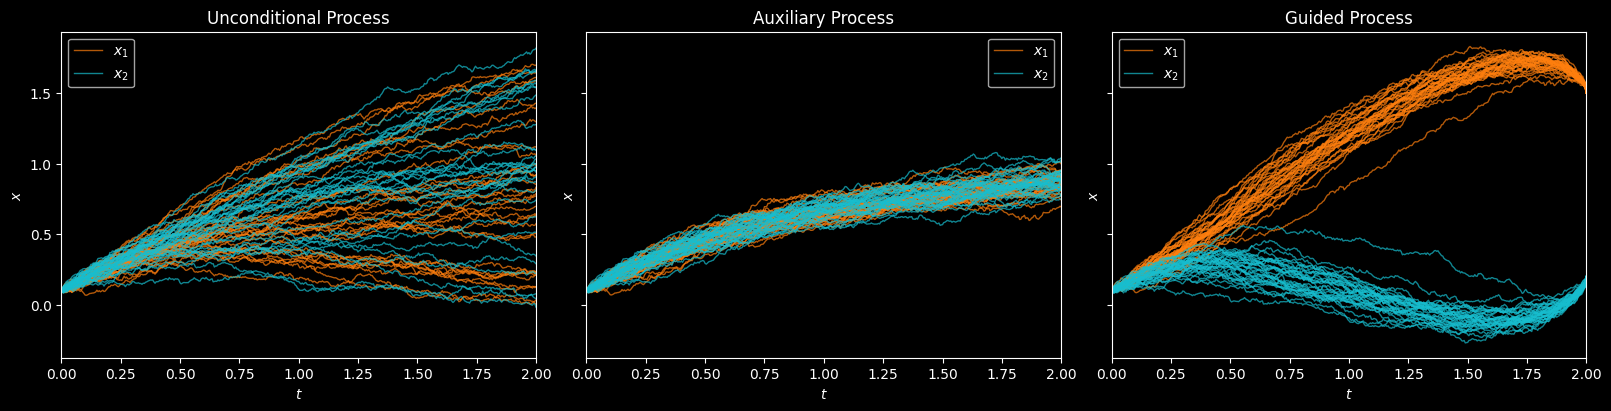

In [18]:
batch_size = 32
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
guided_path = guided_solver.solve(
    x0=u, 
    rng_key=rng_key, 
    batch_size=batch_size, 
    enforce_end_point=v
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=axes[0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Unconditional Process")
plot_sample_path(aux_path, ax=axes[1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Auxiliary Process")
plot_sample_path(guided_path, ax=axes[2], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Process")

In [19]:
neural_net = ScoreNetSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
    norm=None
)

In [20]:
train_config = {
    "save_name": "cell_model_differentiable",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 32,
    "n_iters":100,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [25]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)

In [26]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -54.31726
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_1


Epoch 2:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -63.76285
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_2


Epoch 3:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -72.38232
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_3


Epoch 4:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -74.71371
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_4


Epoch 5:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -73.51167
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_5


Epoch 6:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -76.37252
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_6


Epoch 7:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -76.46478
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_7


Epoch 8:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -78.47943
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_8


Epoch 9:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -79.05208
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_9


Epoch 10:   0%|          | 0/100 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -78.68109
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/cell_model_differentiable/epoch_10


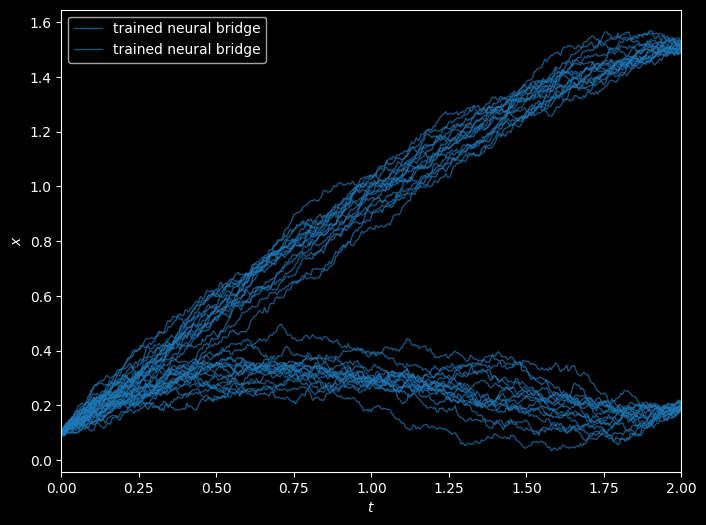

In [27]:
# bridge_solver = Euler(bridge_proc, wiener_proc)
# bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot_sample_path(bridge_path, color="tab:orange", ax=ax, label="true bridge")
plot_sample_path(neural_bridge_path, color="tab:blue", ax=ax, label="trained neural bridge")
plt.show()

In [28]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Iteration 0/5000: log likelihood = 28.178346633911133
INFO:root:Iteration 1000/5000: log likelihood = 143.34947204589844
INFO:root:Iteration 2000/5000: log likelihood = 124.98284149169922
INFO:root:Iteration 3000/5000: log likelihood = 138.60739135742188
INFO:root:Iteration 4000/5000: log likelihood = 132.03128051757812
INFO:root:Batch average acceptance rate: 30.19%


In [35]:
sm_train_config = {
    "save_name": "cell_model",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 32,
    "n_iters": 2000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 250
}

In [36]:
neural_net = ScoreNetSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="gelu",
    norm="batch"
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/cell_model
INFO:root:Loading pretrained model from the last epoch


In [37]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=u)

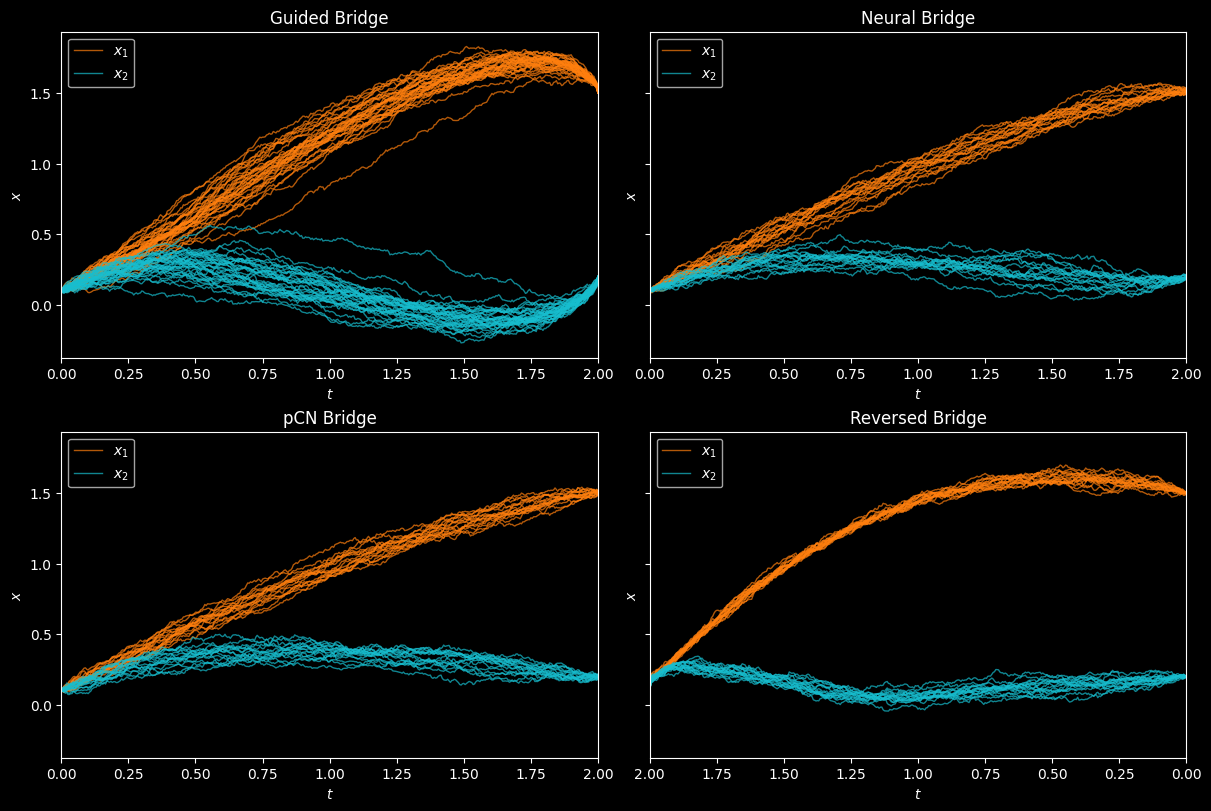

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(guided_path, ax=ax[0, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(neural_bridge_path, ax=ax[0, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plot_sample_path(pCN_result.path_X, ax=ax[1, 0], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(reversed_bridge_path, ax=ax[1, 1], color=["tab:orange", "tab:cyan"], label=["$x_1$", "$x_2$"], title="Reversed Bridge")
ax[1, 1].invert_xaxis()